In [ ]:
#%% Import necessary libraries and dataset description
"""
Dataset Description:
--------------------
The dataset (cumulative.csv) contains astrophysical data related to planetary candidates.
The target variable 'koi_disposition' indicates the disposition of the Kepler Object of Interest.
Each row represents an observation with various numerical features describing planetary characteristics.
"""

In [1]:
#%% Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    roc_curve, auc, confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
"""
Pre-processing:
---------------
1. Load the dataset from a CSV file.
2. Remove columns with all missing values.
3. Fill missing numeric values with the mean.
4. Check and encode the target variable 'koi_disposition'.
5. Select only numerical features and standardize them.
"""

In [2]:
#%% Load and preprocess the dataset
df = pd.read_csv("../data/cumulative.csv")

df.dropna(axis=1, how="all", inplace=True)
df.fillna(df.mean(numeric_only=True), inplace=True)

if 'koi_disposition' in df.columns:
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['koi_disposition'])  # Target variable
else:
    raise ValueError("Dataset must contain 'koi_disposition' column for supervised learning.")

numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numerical_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [3]:
#%% Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [4]:
#%% Define function to train and evaluate models (for parametric transformations)
def train_and_evaluate(X_train_reduced, X_test_reduced, title, model_type="RandomForest"):
    if model_type == "RandomForest":
        clf = RandomForestClassifier()
    else:
        clf = KNeighborsClassifier(n_neighbors=5)
    
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_test_reduced)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f"\n{title} Model Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title} Confusion Matrix")
    plt.show()
    
    # ROC Curve (if applicable for binary classification)
    if len(np.unique(y_test)) == 2:
        y_prob = clf.predict_proba(X_test_reduced)
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{title} (AUC = {roc_auc:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.title(f"{title} ROC Curve")
        plt.show()

In [ ]:
"""
Dimensionality Reduction: PCA
-----------------------------
- PCA reduces the feature space while retaining maximum variance.
- The cumulative explained variance plot helps determine the number of components.
- Performance evaluation helps compare PCA with other techniques.
"""

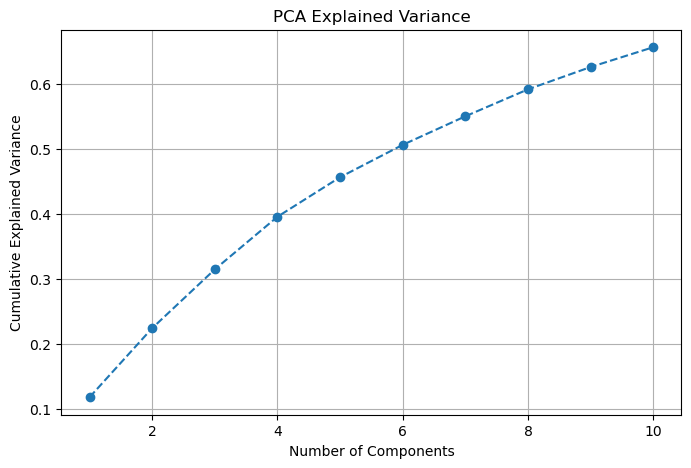


PCA Model Performance:
Accuracy: 0.8411
Precision: 0.8339
Recall: 0.8411
F1-Score: 0.8354

Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.72      0.58      0.64       449
     CONFIRMED       0.77      0.80      0.79       459
FALSE POSITIVE       0.92      0.97      0.94      1005

      accuracy                           0.84      1913
     macro avg       0.80      0.79      0.79      1913
  weighted avg       0.83      0.84      0.84      1913



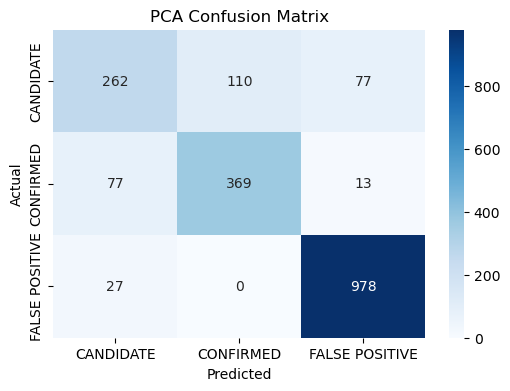

In [5]:
#%% Apply PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Explained Variance Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), marker="o", linestyle="--")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()

train_and_evaluate(X_train_pca, X_test_pca, "PCA")


LDA Model Performance:
Accuracy: 0.8641
Precision: 0.8641
Recall: 0.8641
F1-Score: 0.8641

Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.72      0.73      0.73       449
     CONFIRMED       0.76      0.75      0.75       459
FALSE POSITIVE       0.98      0.98      0.98      1005

      accuracy                           0.86      1913
     macro avg       0.82      0.82      0.82      1913
  weighted avg       0.86      0.86      0.86      1913



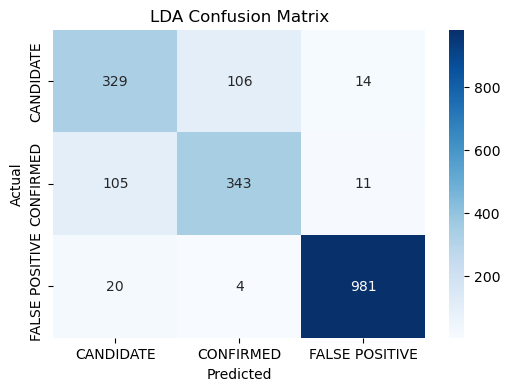

In [6]:
#%% Apply LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
train_and_evaluate(X_train_lda, X_test_lda, "LDA")

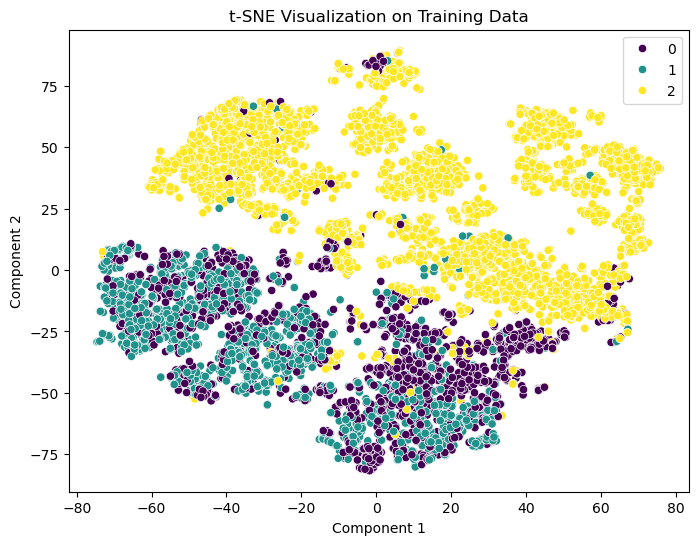

In [7]:
#%% Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_train_tsne = tsne.fit_transform(X_train)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_tsne[:,0], y=X_train_tsne[:,1], hue=y_train, palette="viridis")
plt.title("t-SNE Visualization on Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

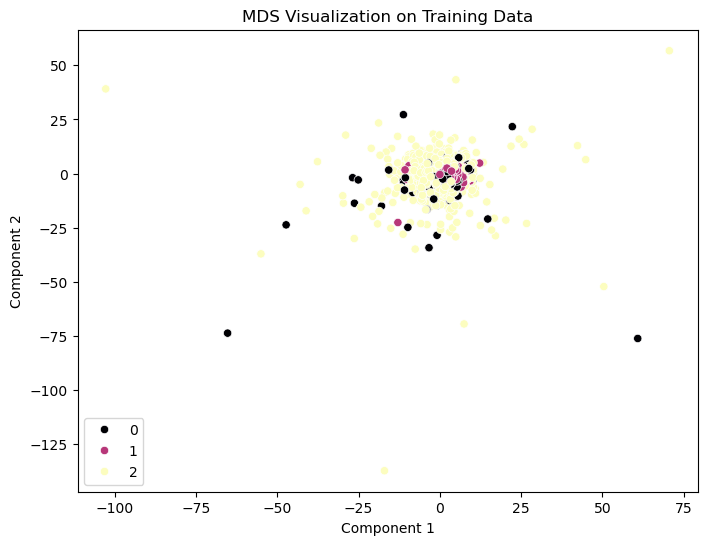

In [8]:
#%% Apply MDS
mds = MDS(n_components=2, random_state=42)
X_train_mds = mds.fit_transform(X_train)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_mds[:,0], y=X_train_mds[:,1], hue=y_train, palette="magma")
plt.title("MDS Visualization on Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [ ]:
"""
Explanation/Reasoning of the Results Obtained:
------------------------------------------------
- PCA vs. SVD:
  Both PCA and SVD aim to reduce dimensionality. PCA works on the covariance matrix while SVD directly factorizes the data matrix.
  Their explained variance plots help us understand the amount of information retained.
  
- LDA:
  As a supervised method, LDA is designed to maximize class separation. This can often lead to better classification performance, especially when classes are well-separated.
  
- t-SNE and MDS:
  These techniques are primarily for visualization. They provide an intuitive understanding of the data distribution and clustering.
  While not directly used for classification, they can indicate potential issues such as class overlap or outliers.
  
Coding Quality and Comments:
-----------------------------
- The code is modular and divided into cells with clear section headers.
- Inline comments explain each step, aiding in readability and future maintenance.
- Function definitions encapsulate model training and evaluation, reducing redundancy.
- Comparative analysis comments help in understanding the pros and cons of each dimensionality reduction technique based on performance and visualization.

Final Note:
-----------
Make sure to update the file path for the dataset if needed. This code is intended to be run in an interactive environment like Jupyter Notebook. Each reduction technique’s performance can be compared by reviewing the printed metrics and visual plots.
"""